In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, average_precision_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Original Training Data Distribution:
Training_Program
0    26
2    24
3    22
1    21
4    18
5    18
6    12
7    11
Name: count, dtype: int64

Training Data Distribution After SMOTE:
Training_Program
7    26
1    26
2    26
4    26
6    26
3    26
5    26
0    26
Name: count, dtype: int64
Fitting 2 folds for each of 50 candidates, totalling 100 fits


C:\Users\licop\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best Parameters for Logistic Regression: {'solver': 'newton-cg', 'multi_class': 'multinomial', 'class_weight': None, 'C': 1000}
Classification Report:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93         7
           1       1.00      0.80      0.89         5
           2       0.80      0.67      0.73         6
           3       0.83      0.83      0.83         6
           4       0.50      0.40      0.44         5
           5       0.50      0.75      0.60         4
           6       0.75      1.00      0.86         3
           7       1.00      0.67      0.80         3

    accuracy                           0.77        39
   macro avg       0.78      0.76      0.76        39
weighted avg       0.79      0.77      0.77        39



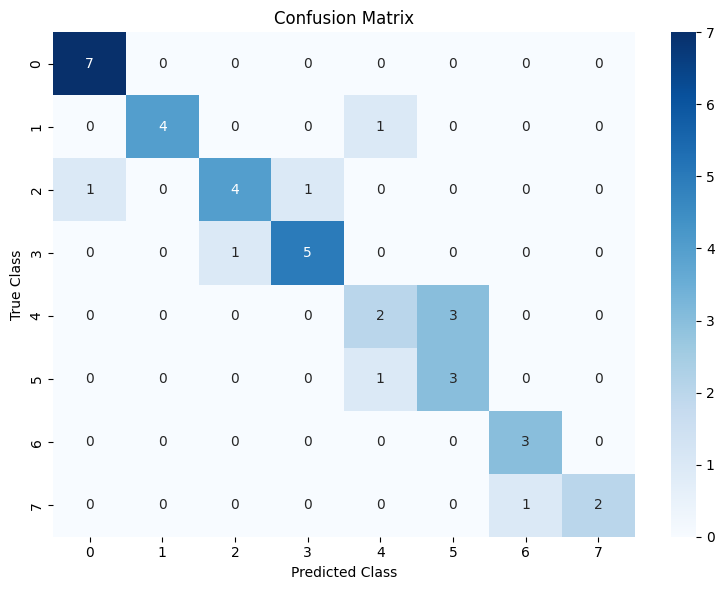

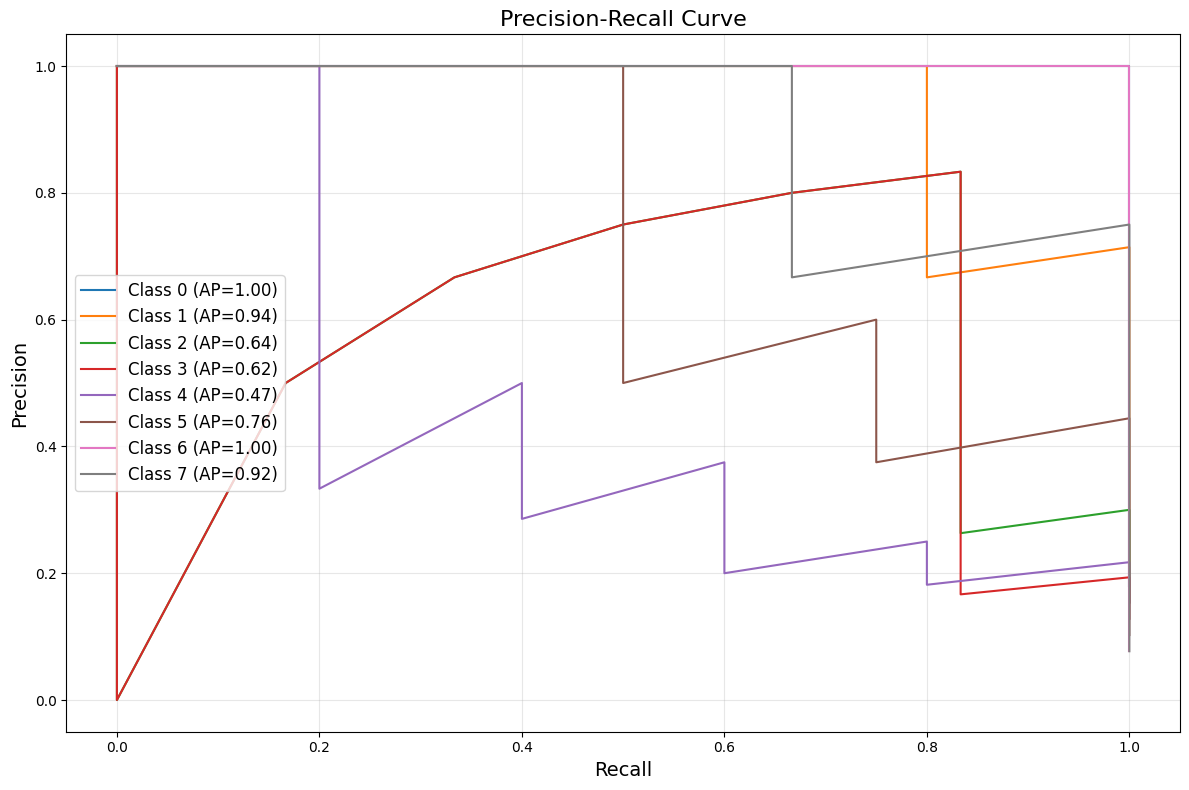


Overall PR AUC (Macro Average): 0.79
Logistic Regression Feature Importances:
               Feature  Importance
12             chest_c   20.056797
5    sports_experience   19.287789
13         right_arm_c   19.126420
1               height   16.226351
15             waist_c   10.728365
8                  BMI   10.681686
3                  age    5.754487
9          W/Hip_Ratio    5.186544
4        resting_pulse    4.702871
16               hip_c    4.647429
6             body_fat    4.463172
18           lower_leg    3.491788
0               gender    3.419706
11          shoulder_c    3.124567
17         upper_leg_c    2.998624
2               weight    2.146416
14          left_arm_c    1.823196
10      W/Height_Ratio    1.169655
20           surgeries    0.984313
7                goals    0.796511
19  chronic_conditions    0.211909


C:\Users\licop\AppData\Local\Temp\ipykernel_25232\1600002794.py:119: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=log_importances, x='Importance', y='Feature', palette='viridis')


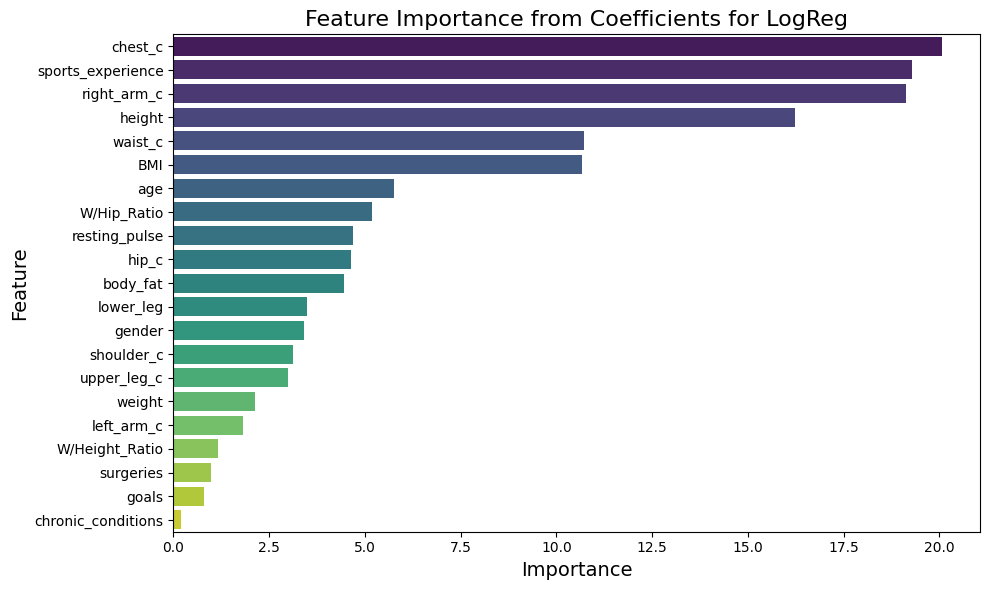

In [3]:
# Define the seed for reproducibility
seed = 12 

# Load the dataset
VT = pd.read_csv("data/processed_VT_Data.csv")
pd.set_option('display.max_columns', None)

# Separate features and target variable
X = VT.drop(columns=["Training_Program"])
y = VT["Training_Program"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed, stratify=y)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Generate synthetic data with SMOTE
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("Original Training Data Distribution:")
print(pd.Series(y_train).value_counts())
print("\nTraining Data Distribution After SMOTE:")
print(pd.Series(y_train_resampled).value_counts())

# Define the Logistic Regression model
logreg_model = LogisticRegression(max_iter=1000, random_state=seed)

# Define hyperparameters for optimization
param_dist = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'],
    'multi_class': ['ovr', 'multinomial'],
    'class_weight': [None, 'balanced']
}

# Perform Randomized Search with Cross-Validation
random_search_logreg = RandomizedSearchCV(
    estimator=logreg_model,
    param_distributions=param_dist,
    n_iter=50,
    scoring='accuracy',
    cv=2,
    random_state=seed,
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV
random_search_logreg.fit(X_train_resampled, y_train_resampled)

# Best parameters and model performance
print("Best Parameters for Logistic Regression:", random_search_logreg.best_params_)

# Get the best estimator from RandomizedSearchCV
best_logreg = random_search_logreg.best_estimator_

# Predict on the test data
y_pred = best_logreg.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=best_logreg.classes_, yticklabels=best_logreg.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.tight_layout()
plt.show()

# Precision-Recall Curve and PR AUC
# Binarize the true labels (One-vs-Rest approach for multi-class PR Curve)
y_test_binarized = label_binarize(y_test, classes=best_logreg.classes_)
y_pred_probabilities = best_logreg.predict_proba(X_test)  # Get class probabilities

# Initialize PR Curve plot
plt.figure(figsize=(12, 8))

# Loop through each class to calculate PR Curve and AUC
for i, class_label in enumerate(best_logreg.classes_):
    precision, recall, _ = precision_recall_curve(y_test_binarized[:, i], y_pred_probabilities[:, i])
    auc_score = average_precision_score(y_test_binarized[:, i], y_pred_probabilities[:, i])
    plt.plot(recall, precision, label=f'Class {class_label} (AP={auc_score:.2f})')

# Plot settings
plt.title('Precision-Recall Curve', fontsize=16)
plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.legend(loc='best', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Calculate Macro Average PR AUC
overall_pr_auc = average_precision_score(y_test_binarized, y_pred_probabilities, average="macro")
print(f"\nOverall PR AUC (Macro Average): {overall_pr_auc:.2f}")

# Extract feature importances (coefficients) from the best model
log_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': np.abs(best_logreg.coef_[0])  # Absolute value of coefficients
}).sort_values(by='Importance', ascending=False)

# Display the feature importances
print("Logistic Regression Feature Importances:")
print(log_importances)

# Plot feature importance
plt.figure(figsize=(10, 6))
sns.barplot(data=log_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Feature Importance from Coefficients for LogReg', fontsize=16)
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()